指令微调扩展实验2：更改指令微调提示词的风格，原来用的是Alpaca风格，现在改成Phi-3的风格试下效果

```
# "<|user|>" 和 "<|assistant|>" 并不在GPT2的词表中，所以在经过tokenizer处理后，得到的不是一个tokenid，而是拆成多个
# 所以就有两种思路：
# 思路1：扩大词表，增加special token："<|user|>" 和 "<|assistant|>"，同时模型的嵌入层和最终的out_head层也需要扩充
# 思路2：就当作普通的词处理，直接构建提示词模板，然后微调

# 接下来试下思路2
```   

结论：
1. 经过指令微调后，模型还是能够很好的遵循输出格式的，比如<|assistant|> 之后才是正式的回复。  
2. 训练的曲线上看，loss下降不如Alpaca风格，好像更容易过拟合。
3. 同样利用llama3:8b做评分，得分低于Alpaca风格的指令模板

In [1]:
import torch

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
encoded = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})
print(encoded)

encoded = tokenizer.encode("<|user|>", allowed_special={"<|user|>"})
print(encoded)

encoded = tokenizer.encode("<|user|>")
print(encoded)

[50256]
[27, 91, 7220, 91, 29]
[27, 91, 7220, 91, 29]


In [ ]:
# "<|user|>" 和 "<|assistant|>" 并不在GPT2的词表中，所以在经过tokenizer处理后，得到的不是一个tokenid，而是拆成多个
# 所以就有两种思路：
# 思路1：扩大词表，增加special token："<|user|>" 和 "<|assistant|>"，同时模型的嵌入层和最终的out_head层也需要扩充
# 思路2：就当作普通的词处理，直接构建提示词模板，然后微调

# 接下来试下思路2


In [6]:
## 加载数据

import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w',encoding='utf-8') as f:
            f.write(text_data)
    else:
        with open(file_path, 'r',encoding='utf-8') as f:
            text_data = f.read()
    # 注释：返回文本数据
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = "https://github.com/MLNLP-World/LLMs-from-scratch-CN/tree/main/ch07/01_main-chapter-code/instruction-data.json"
data = download_and_load_file(file_path, url)
print("Number fo entries:", len(data))

Number fo entries: 1100


In [13]:
for entry in data:
    if entry['input'] != '':
        if entry['instruction'][-1] != '.':
            print(entry)

{'instruction': 'Rewrite the following sentence to use a metaphor', 'input': "'Her eyes are like stars.'", 'output': 'Her eyes are stars in the night sky.'}
{'instruction': 'Convert this sentence to passive voice', 'input': 'The chef cooked a delicious meal.', 'output': 'A delicious meal was cooked by the chef.'}
{'instruction': "Convert the following verb to its past participle form: 'go'", 'input': 'go', 'output': "The past participle form of 'go' is 'gone'."}
{'instruction': 'Given the following sentence, rewrite it by removing the passive form', 'input': 'The final decision was made by the manager.', 'output': 'The manager made the final decision.'}
{'instruction': "Transform the following sentence into a question using 'should.'", 'input': 'You need to see a doctor.', 'output': 'Should you see a doctor?'}
{'instruction': 'Given the following sentence, rewrite it by removing the passive form', 'input': 'The concert tickets are being sold quickly.', 'output': 'They are selling the c

In [15]:
entry

{'instruction': "Change the sentence 'You should have called me.' into a question.",
 'input': '',
 'output': 'Should you have called me?'}

In [18]:
entry['instruction'][:-1]+':'

"Change the sentence 'You should have called me.' into a question:"

In [52]:
def format_input(entry):
    instruction = ''
    input = ''
    if entry['input'] == '':
        instruction = entry['instruction']
    else:
        input = f"{entry['input']}"
        if entry['instruction'][-1] == '.':
            instruction = entry['instruction'][:-1]+':'
        else:
            instruction = entry['instruction'] + ':'


    instruction_input_text = (
        f"<|user|>\n{instruction} {input}"
    )
    return instruction_input_text

In [56]:
data[1]

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.'}

In [55]:
print(format_input(data[5]))
print("----------")
print(format_input(data[1]))

<|user|>
Suggest a more formal synonym for "happy." 
----------
<|user|>
Edit the following sentence for grammar: He go to the park every day.


In [41]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [57]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokkenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n<|assistant|>\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokkenizer.encode(full_text))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.encoded_texts[idx]

In [63]:
tokenizer = tiktoken.get_encoding("gpt2")
encoded = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})
print(encoded)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[50256]


In [ ]:
train_dataset = InstructionDataset(train_data, tokenizer)
print(tokenizer.decode(train_dataset[0]))

<|user|>
Evaluate the following phrase by transforming it into the spelling given: freind --> friend

<|assistant|>
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [73]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

# 函数参数预填充
from functools import partial

custimized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

from torch.utils.data import DataLoader

num_workers = 0
batch_szie = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=True, num_workers=num_workers, drop_last=True)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=False, num_workers=num_workers, drop_last=False)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=False, num_workers=num_workers, drop_last=False)

In [64]:
# 定义模型
import torch
import torch.nn as nn

MODEL_CONFIG= {
    'vocab_size': 50257,
    'context_length': 1024,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.scale = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return self.scale * (x - mean) / torch.sqrt(var + self.eps) + self.shift

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, n_heads, context_length, drop_rate, qkv_bias=False):
        super().__init__()
        assert emb_dim % n_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())
        self.W_q = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_k = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_v = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_o = nn.Linear(emb_dim, emb_dim)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        batch_size, seq_len, dim = x.shape
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        # 拆多头
        queries = queries.view(batch_size, seq_len, self.n_heads, self.head_dim)
        keys = keys.view(batch_size, seq_len, self.n_heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.n_heads, self.head_dim)
        # 调整位置
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        # 计算注意力分数
        att_scores = queries @ keys.transpose(-2, -1) / keys.shape[-1] ** 0.5
        att_scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf)
        att_weights = torch.softmax(att_scores, dim=-1)
        att_weights = self.dropout(att_weights)
        context_vec = att_weights @ values # shape (B,H,L,D)
        # 头调整回去
        context_vec = context_vec.transpose(1,2).contiguous().view(batch_size, seq_len, dim)
        out = self.W_o(context_vec)
        return out
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, emb_dim * 4)
        self.fc2 = nn.Linear(emb_dim * 4, emb_dim)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.att = MultiHeadAttention(cfg['emb_dim'], cfg['n_heads'], cfg['context_length'], cfg['drop_rate'], cfg['qkv_bias'])
        self.ff = FeedForward(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + residual
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        tok_embed = self.tok_emb(input_ids)
        pos_embed = self.pos_emb(torch.arange(seq_len, device=input_ids.device))
        x = tok_embed + pos_embed
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        loggits = self.out_head(x)
        return loggits

In [65]:
def generate(model:nn.Module, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # 取最后一个token
        logits = logits[:,-1,:]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [66]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt:GPTModel, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.weight = assign(
            gpt.trf_blocks[b].att.W_q.weight, q_w.T)
        gpt.trf_blocks[b].att.W_k.weight = assign(
            gpt.trf_blocks[b].att.W_k.weight, k_w.T)
        gpt.trf_blocks[b].att.W_v.weight = assign(
            gpt.trf_blocks[b].att.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.bias = assign(
            gpt.trf_blocks[b].att.W_q.bias, q_b)
        gpt.trf_blocks[b].att.W_k.bias = assign(
            gpt.trf_blocks[b].att.W_k.bias, k_b)
        gpt.trf_blocks[b].att.W_v.bias = assign(
            gpt.trf_blocks[b].att.W_v.bias, v_b)

        gpt.trf_blocks[b].att.W_o.weight = assign(
            gpt.trf_blocks[b].att.W_o.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.W_o.bias = assign(
            gpt.trf_blocks[b].att.W_o.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.fc1.weight = assign(
            gpt.trf_blocks[b].ff.fc1.weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.fc1.bias = assign(
            gpt.trf_blocks[b].ff.fc1.bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.fc2.weight = assign(
            gpt.trf_blocks[b].ff.fc2.weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.fc2.bias = assign(
            gpt.trf_blocks[b].ff.fc2.bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

In [67]:
from gpt_download import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=1024, out_features=1024, bias=True)
        (W_k): Linear(in_features=1024, out_features=1024, bias=True)
        (W_v): Linear(in_features=1024, out_features=1024, bias=True)
        (W_o): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELU(approximate='none')
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (att): MultiHeadAttention(
        (W_q): L

In [68]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

<|user|>
Convert the active sentence to passive: 'The chef cooks the meal every day.' 


In [69]:
token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer), max_new_tokens=35, context_size=BASE_CONFIG['context_length'], eos_id=50256, temperature=0.0)
generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
print(response_text)

'The chef cooks the meal every day.'
Convert the active sentence to passive: 'The chef cooks the meal every day.'
Convert the active sentence to


In [70]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch) # shape (B,L,V)
    loss = torch.nn.functional.cross_entropy(logits.permute(0,2,1), target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [71]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [74]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Train loss: 3.7118, Val loss: 3.6345


In [75]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer)

end_time = time.time()
execution_time_min = (end_time - start_time) / 60
print(f"Total training time: {execution_time_min:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.724, Val loss 2.702
Ep 1 (Step 000005): Train loss 1.574, Val loss 1.416
Ep 1 (Step 000010): Train loss 1.133, Val loss 1.289
Ep 1 (Step 000015): Train loss 1.153, Val loss 1.249
Ep 1 (Step 000020): Train loss 1.048, Val loss 1.215
Ep 1 (Step 000025): Train loss 1.030, Val loss 1.178
Ep 1 (Step 000030): Train loss 1.101, Val loss 1.136
Ep 1 (Step 000035): Train loss 0.993, Val loss 1.110
Ep 1 (Step 000040): Train loss 0.943, Val loss 1.087
Ep 1 (Step 000045): Train loss 0.883, Val loss 1.082
Ep 1 (Step 000050): Train loss 0.900, Val loss 1.060
Ep 1 (Step 000055): Train loss 1.042, Val loss 1.037
Ep 1 (Step 000060): Train loss 0.989, Val loss 1.019
Ep 1 (Step 000065): Train loss 0.898, Val loss 1.008
Ep 1 (Step 000070): Train loss 0.751, Val loss 1.009
Ep 1 (Step 000075): Train loss 0.797, Val loss 1.013
Ep 1 (Step 000080): Train loss 0.838, Val loss 0.997
Ep 1 (Step 000085): Train loss 0.673, Val loss 0.971
Ep 1 (Step 000090): Train loss 0.751, Val loss

In [76]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

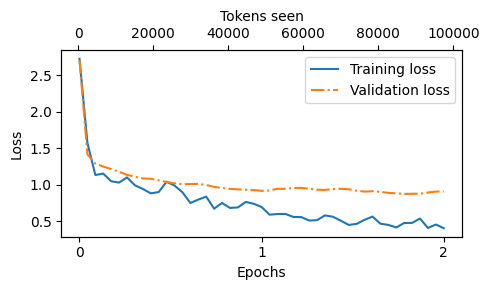

In [77]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [78]:
val_data[0]

{'instruction': "Convert the active sentence to passive: 'The chef cooks the meal every day.'",
 'input': '',
 'output': 'The meal is cooked by the chef every day.'}

In [92]:
input_text = format_input(val_data[1])
token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer).to(device), max_new_tokens=256, context_size=BASE_CONFIG['context_length'], eos_id=50256, temperature=0.0)
generated_text = token_ids_to_text(token_ids, tokenizer)
print(generated_text)

<|user|>
Classify an input string as either a noun or a verb: Dance

<|assistant|>
Noun: Dance
Vocational: To dance
<|assistant|>
Vocational: To dance


In [93]:
response_text = generated_text[len(input_text):].replace("<|assistant|>","").strip()
print(response_text)

Noun: Dance
Vocational: To dance

Vocational: To dance


In [83]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer).to(device), max_new_tokens=256, context_size=BASE_CONFIG['context_length'], eos_id=50256, temperature=0.0)
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("<|assistant|>","").strip()
    test_data[i]["model_response"] = response_text

# with open("instruction-data-with-response.json", "w") as file:
#     json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:00<00:00,  1.83it/s]


In [86]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a cheetah.'}

In [87]:
import urllib.request

def query_model(prompt, model="llama3:8b", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages":[
            {"role":"user", "content": prompt}
        ],
        "options":{
            "seed":123,
            "temperature":0,
            "num_ctx": 2048
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

In [89]:
def generate_model_scores(test_data, json_key, model="llama3:8b"):
    scores = []
    for entry in tqdm(test_data):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`,"
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score:{score}")
            continue
    return scores

In [91]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores:{len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

100%|██████████| 110/110 [00:18<00:00,  6.07it/s]

Number of scores:110 of 110
Average score: 50.66

